In [1]:
!pip install -U datasets
!pip install transformers_stream_generator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [8]:
from datasets import load_dataset
dataset = load_dataset("gsm8k", "main", split="train[:10]", cache_dir="./hf_cache")

# for example in dataset:
#     print("Q:", example["question"], "A:", example["answer"])


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
# model_name = "Qwen/Qwen2.5-7B-Instruct-1M"
# model_name = "Qwen/Qwen-1_8B-Chat"
model_name = "gpt2"


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
model.eval()


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
import torch
import torch.nn.functional as F
import numpy as np

class TopKSamplerWithEntropy:
    def __init__(self, model, tokenizer, k=10, max_length=50):
        self.model = model
        self.tokenizer = tokenizer
        self.k = k
        self.max_length = max_length

    def compute_entropy(self, probs):
        return -torch.sum(probs * probs.log(), dim=-1).item() # H(p)=−∑p(x)logp(x), entropy for the output probability distribution:


    def compute_layerwise_entropy(self, hidden_states):
        """
        Compute entropy for each layer's hidden state at the last token position.
        Normalize and apply softmax across hidden dimensions.
        Here we are computing entropy of that vector as if it were a probablilty distribution.
        But hidden states are not probability distributions. But it can still give a useful signal about how focused the layer’s activation is.

        Output: a list of entropies — one per layer per step.
        """
        entropies = []
        for layer in hidden_states:
            last_token_vec = layer[0, -1, :]  # [hidden_dim]
            probs = F.softmax(last_token_vec, dim=-1)
            entropy = -torch.sum(probs * probs.log()).item()
            entropies.append(entropy)
        return entropies  # one value per layer

    def sample(self, prompt):
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt")
        output_ids = input_ids.clone()

        output_entropies = []
        layerwise_entropies = []

        for _ in range(self.max_length):
            with torch.no_grad():
                outputs = self.model(output_ids, output_hidden_states=True)
                logits = outputs.logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)

                # Output entropy
                entropy = self.compute_entropy(probs)
                output_entropies.append(entropy)

                # Layerwise entropy
                hidden_states = outputs.hidden_states  # tuple of [layer_i] each of shape [1, seq_len, hidden_dim]
                layer_entropies = self.compute_layerwise_entropy(hidden_states)
                layerwise_entropies.append(layer_entropies)

                # Top-k sampling
                topk_probs, topk_indices = torch.topk(probs, self.k, dim=-1)
                topk_probs = topk_probs / topk_probs.sum(dim=-1, keepdim=True)
                next_token = torch.multinomial(topk_probs, num_samples=1)
                next_token_id = topk_indices.gather(-1, next_token)
                output_ids = torch.cat([output_ids, next_token_id], dim=-1)

        generated_text = self.tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return generated_text, output_entropies, layerwise_entropies


In [5]:
sampler = TopKSamplerWithEntropy(model, tokenizer, k=10, max_length=30)

for i, example in enumerate(dataset):
    print(f"\nExample {i + 1}")
    prompt = example["question"]
    print("Prompt:", prompt)

    generated, output_entropies, layerwise_entropies = sampler.sample(prompt)
    print("Generated:", generated)
    print("Output entropy:", output_entropies)
    print("Layerwise entropy (per step):")
    for step_idx, entropies in enumerate(layerwise_entropies):
        print(f"Step {step_idx + 1}: {entropies}")



Example 1
Prompt: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Generated: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May? She had about 4,000. She sold a lot more clips in April. She was selling a lot less clips in May, when she sold a
Output entropy: [4.613737106323242, 2.9114346504211426, 5.042381763458252, 4.7449116706848145, 1.7092541456222534, 1.376247763633728, 3.9049253463745117, 4.026247024536133, 3.0243279933929443, 5.5215888023376465, 4.886738300323486, 1.4722548723220825, 3.5227012634277344, 2.7470078468322754, 2.2583227157592773, 1.7419567108154297, 3.8880395889282227, 2.289374828338623, 4.024837017059326, 5.692749977111816, 0.8259275555610657, 0.9852944016456604, 2.3829092979431152, 1.9582412242889404, 0.9153819680213928, 1.4069080352783203, 3.6181092262268

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_entropies(prompt, generated_text, output_entropies, layerwise_entropies, save_path=None):
    num_layers = len(layerwise_entropies)
    num_tokens = len(output_entropies)

    fig, axs = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2]})
    fig.suptitle("Top-k Sampling and Entropy Visualization", fontsize=16)

    # FOR Output entropy over generation steps
    axs[0].plot(range(1, num_tokens + 1), output_entropies, marker='o', label="Output Entropy")
    axs[0].set_title("Token-wise Output Entropy")
    axs[0].set_xlabel("Generation Step")
    axs[0].set_ylabel("Entropy")
    axs[0].grid(True)
    axs[0].legend()

    # FOR  Layer-wise entropy heatmap
    entropy_matrix = np.array(layerwise_entropies)  # shape: [num_layers, num_tokens]
    sns.heatmap(entropy_matrix, ax=axs[1], cmap="viridis", xticklabels=True, yticklabels=True)
    axs[1].set_title("Layerwise Entropy Heatmap")
    axs[1].set_xlabel("Generation Step")
    axs[1].set_ylabel("Layer")

    plt.tight_layout(rect=[0, 0, 1, 0.96])



Prompt: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?
Generated: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?

In April of 2016, she sold a clip to a friend, who gave her a coupon for $25 worth of clips. What was the
Output Entropies: [4.613737106323242, 0.01790897361934185, 5.735810279846191, 4.434947967529297, 2.38517165184021, 3.2061846256256104, 1.3664222955703735, 5.319614410400391, 1.1511001586914062, 5.305612087249756, 5.304421424865723, 2.9707515239715576, 5.759100914001465, 5.025137424468994, 3.0371830463409424, 4.728143215179443, 4.322721481323242, 2.1066882610321045, 4.125067710876465, 6.224639892578125, 2.757028818130493, 4.016139507293701, 3.8408830165863037, 3.1616458892822266, 0.22261177003383636, 6.627562522888184, 2.209707021713257, 4.216978549957275, 

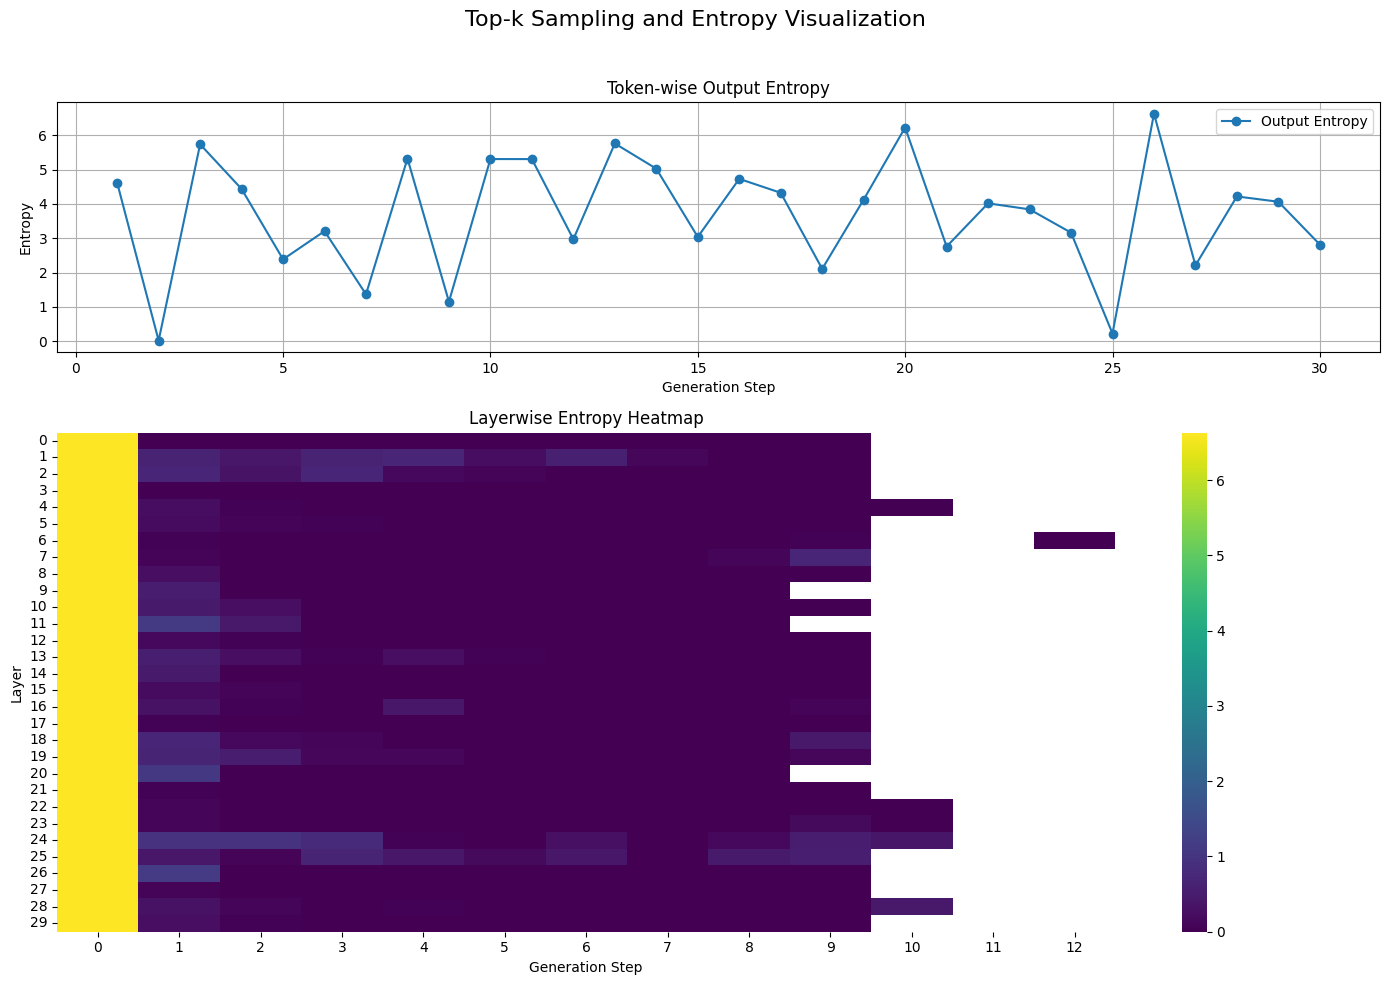

In [7]:
# TESTING with examples from the dataset
example = dataset[0]
prompt = example["question"]

generated, output_entropies, layerwise_entropies = sampler.sample(prompt)

print("Prompt:", prompt)
print("Generated:", generated)
print("Output Entropies:", output_entropies)

# Visualize
visualize_entropies(prompt, generated, output_entropies, layerwise_entropies)
